In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [5]:
demo_df = pd.read_csv('Datasets/demo_data.csv')
onlinecontent_df = pd.read_csv('Datasets/onlinecontent_data.csv')
subs_df = pd.read_csv('Datasets/subs_data.csv')
viewership_df = pd.read_csv('Datasets/viewership_data.csv')


In [31]:
seed = 23
score_threshold = 0.2

### Match Show Name in Viewership and Online Content

In [6]:
# Remove punctuation from the 'Show Name' column
viewership_df['Show Name'] = viewership_df['Show Name'].str.replace(r"[^\w\s]", "", regex=True)

# Capitalize the first letter of every word
viewership_df['Show Name'] = viewership_df['Show Name'].str.title()

In [7]:
def extract_show_name(url):
    # Extract the part after the last slash
    last_part = url.split('/')[-1]
    
    # Remove trailing season or preview patterns
    # This regex removes "-season-" followed by digits or "-preview"
    last_part = re.sub(r'(-season-\d+|-preview|-episode|-exclusive|-special|-free|-new|-guide|-trial)', '', last_part, flags=re.IGNORECASE)
    # Check if there is a '?' in the show name and split if it exists
    if '?' in last_part:
        last_part = last_part.split('?')[0]
    # Replace hyphens with spaces, strip extra spaces, and title-case the result
    show_name = last_part.replace('-', ' ').strip().title()
    return show_name

# Apply the function to create a new column 'Show Name'
onlinecontent_df['Show Name'] = onlinecontent_df['URL'].apply(extract_show_name)
# Replace the specific value in the 'Show Name' column
onlinecontent_df['Show Name'] = onlinecontent_df['Show Name'].replace('Retro Sci Fi Space And Beyond', 'Retro Scifi Space And Beyond')

In [8]:
# Get unique values from both columns
onlinecontent_unique = set(onlinecontent_df['Show Name'].unique())
viewership_unique = set(viewership_df['Show Name'].unique())

# Find unique values in each dataframe
unique_onlinecontent = onlinecontent_unique - viewership_unique
unique_viewership = viewership_unique - onlinecontent_unique

# Display the different values
print("Unique values in onlinecontent_df['Show Name'] not in viewership_df['Show Name']:")
print(unique_onlinecontent)

print("\nUnique values in viewership_df['Show Name'] not in onlinecontent_df['Show Name']:")
print(unique_viewership)

Unique values in onlinecontent_df['Show Name'] not in viewership_df['Show Name']:
{'Architects Of History', 'Race Against Time', 'The Cursed Woods', 'Echoes Of The Mind', 'Twisted Truths', 'The Unknown Universe', 'Parallel Worlds', 'Celestial Voyage', 'The Misadventures Of Sam', 'Hidden Agenda', 'Blood Moon Rising'}

Unique values in viewership_df['Show Name'] not in onlinecontent_df['Show Name']:
set()


### Online Content EDA

In [10]:
# Remove rows where SCORE is less than 0.2
onlinecontent_df = onlinecontent_df[onlinecontent_df['SCORE'] >= score_threshold]

In [11]:
unique_pairs = viewership_df[['Show Name', 'Network']].drop_duplicates()
duplicate_show_names = unique_pairs.groupby('Show Name').filter(lambda x: len(x) > 1)
paid_network = ['Pulse', 'Lime Light', 'ChillStream', 'RetroReel', 'CineQuest']
# Create a mask for duplicate show names
mask = unique_pairs['Show Name'].isin(duplicate_show_names['Show Name']) & ~unique_pairs['Network'].isin(paid_network)
# Filter out the rows
filtered_unique_pairs = unique_pairs[~mask]
filtered_unique_pairs

,Show Name,Network
0,The Perfect Party Planner,Lime Light
1,Highway Heist,Pulse
2,Echoes Of Love,HeartStream
3,The Forgotten Kingdom,CineQuest
4,Style Seekers Global Trends,Lime Light
...,...,...
391,Surviving Antarctica The Final Frontier,ChillStream
396,Fitness Gurus Transformations,Lime Light
403,Echoes Of The Past,CineQuest
449,Unwritten Laws,CineQuest


In [12]:
onlinecontent_df = onlinecontent_df.merge(filtered_unique_pairs, on='Show Name', how='left')
onlinecontent_df = onlinecontent_df.dropna()
onlinecontent_df['DATE'] = pd.to_datetime(onlinecontent_df['DATE'])
onlinecontent_df

,Capstone_id,DATE,URL,SCORE,Show Name,Network
0,JZT0614778,2024-09-05,www.streamit.net/target-locked-season-1,0.729427,Target Locked,Pulse
2,YDM5306828,2024-01-10,watch.streamit.net/hollywood-gold-the-best-of-...,0.782238,Hollywood Gold The Best Of The Silver Screen,RetroReel
3,KKW0137917,2024-10-14,hub.example.com/flight-risk-exclusive,0.414174,Flight Risk,Pulse
4,YAO3074356,2024-04-16,hub.streamit.net/deep-waters-submarine-showdow...,0.418987,Deep Waters Submarine Showdown,Pulse
6,QBD6861585,2024-03-27,hub.myshow.tv/highway-heist-season-1,0.560582,Highway Heist,Pulse
...,...,...,...,...,...,...
839968,VXY5247161,2024-06-01,www.streamit.net/unsolved-mysteries-season-1,0.650544,Unsolved Mysteries,DocuWorld
839969,FIS4812204,2024-10-24,www.streamit.net/hidden-civilizations-free-trial,0.439062,Hidden Civilizations,DocuWorld
839970,AFQ3379202,2024-02-26,hub.streamit.net/operation-blackout-new,0.821388,Operation Blackout,ActionMax
839971,SXW7973614,2024-06-30,view.watchhub.org/haunted-reflections-free-trial,0.397102,Haunted Reflections,HorrorHaven


In [13]:
def groupby_df_online(df, date):
    current_day = pd.to_datetime(date)
    
    # Group by 'ID' and 'NETWORK' to find the first and last watch dates
    df_watch_dates = df.groupby(['Capstone_id', 'Network'])['DATE'].agg(
        FIRST_WATCH_DATE='min',
        LAST_WATCH_DATE='max'
    ).reset_index()
    
    # Calculate 'TENURE' as the difference between last and first watch dates
    df_watch_dates['TENURE_online'] = (df_watch_dates['LAST_WATCH_DATE'] - df_watch_dates['FIRST_WATCH_DATE']).dt.days + 1
    # Calculate 'RECENCY' as the difference between current day and last watch date
    df_watch_dates['RECENCY_online'] = (current_day - df_watch_dates['LAST_WATCH_DATE']).dt.days
    
    # Group by 'ID' and 'NETWORK' to find the number of sessions as 'FREQUENCY'
    df_num_sessions = df.groupby(['Capstone_id', 'Network']).size().reset_index(name='FREQUENCY_online')
    
    # Merge all data into a final DataFrame
    df_final = pd.merge(df_watch_dates, df_num_sessions, on=['Capstone_id', 'Network'])
    
    df_final = df_final[['Capstone_id', 'Network', 'RECENCY_online', 'FREQUENCY_online', 'TENURE_online']]
    
    return df_final

In [15]:
online_final = groupby_df_online(onlinecontent_df, '2025-01-01')
online_final

,Capstone_id,Network,RECENCY_online,FREQUENCY_online,TENURE_online
0,AAA0353325,CineQuest,269,1,1
1,AAA0353325,DocuWorld,206,1,1
2,AAA0353325,HeartStream,113,2,145
3,AAA0353325,HistoryWatch,116,1,1
4,AAA0353325,HorrorHaven,55,2,155
...,...,...,...,...,...
561510,ZZZ8498042,ActionMax,199,1,1
561511,ZZZ8498042,ChillStream,127,1,1
561512,ZZZ8498042,CineQuest,35,1,1
561513,ZZZ8498042,KidsZone,364,1,1


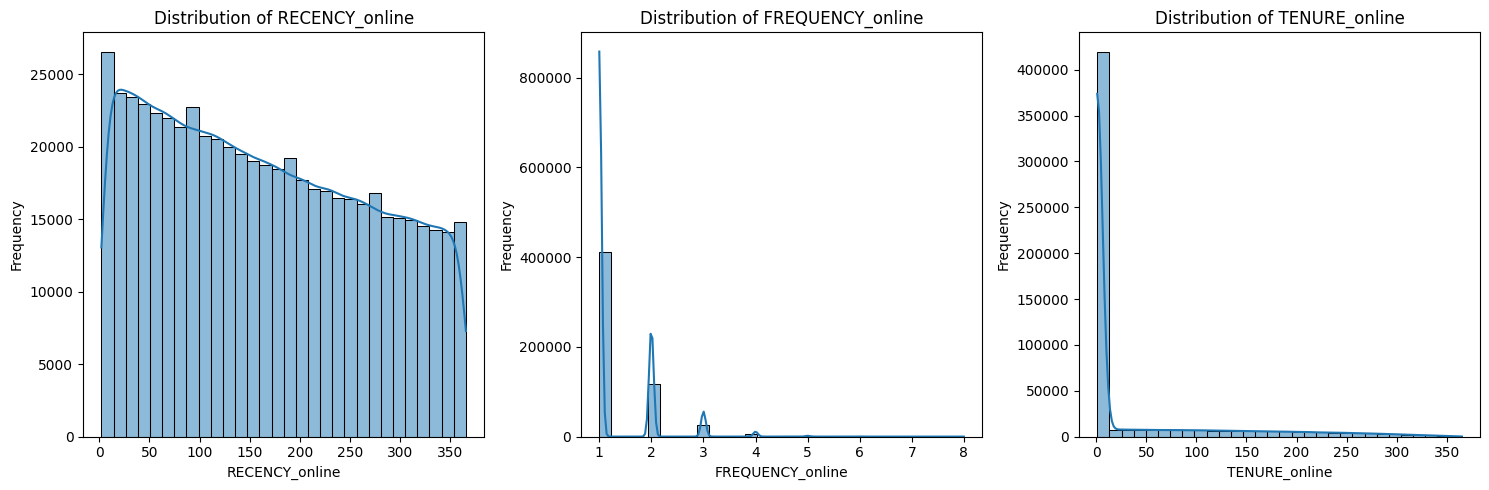

In [16]:
# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot distribution for RECENCY_online
plt.subplot(1, 3, 1)
sns.histplot(online_final['RECENCY_online'], bins=30, kde=True)
plt.title('Distribution of RECENCY_online')
plt.xlabel('RECENCY_online')
plt.ylabel('Frequency')

# Plot distribution for FREQUENCY_online
plt.subplot(1, 3, 2)
sns.histplot(online_final['FREQUENCY_online'], bins=30, kde=True)
plt.title('Distribution of FREQUENCY_online')
plt.xlabel('FREQUENCY_online')
plt.ylabel('Frequency')

# Plot distribution for TENURE_online
plt.subplot(1, 3, 3)
sns.histplot(online_final['TENURE_online'], bins=30, kde=True)
plt.title('Distribution of TENURE_online')
plt.xlabel('TENURE_online')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

### Viewership EDA

In [17]:
# Ensure the time columns are in datetime format
viewership_df['Time Started'] = pd.to_datetime(viewership_df['Time Started'])
viewership_df['Time Ended'] = pd.to_datetime(viewership_df['Time Ended'])

# Calculate watch time for each entry
viewership_df['Watch Minutes'] = (viewership_df['Time Ended'] - viewership_df['Time Started']).dt.total_seconds() / 60  # Convert to minutes

# filter Watch Minutes >= 6 mins
viewership_df = viewership_df[viewership_df['Watch Minutes'] >= 6]

# Create new columns for Year, Month, and Weekday
viewership_df['Year'] = viewership_df['Time Started'].dt.year
viewership_df['Month'] = viewership_df['Time Started'].dt.month
viewership_df['Weekday'] = viewership_df['Time Started'].dt.day_name() 

viewership_df

,Capstone_id,Time Started,Time Ended,Show Name,Network,Genre,Watch Minutes,Year,Month,Weekday
0,JZT0614778,2024-09-05 07:53:00,2024-09-05 08:13:00,The Perfect Party Planner,Lime Light,Reality TV,20.0,2024,9,Thursday
1,KTE7341320,2024-01-10 17:07:00,2024-01-10 18:47:00,Highway Heist,Pulse,Adventure,100.0,2024,1,Wednesday
2,XAM5059147,2024-04-16 19:27:00,2024-04-16 20:04:00,Echoes Of Love,HeartStream,Romance,37.0,2024,4,Tuesday
3,LWK9505947,2024-03-27 16:28:00,2024-03-27 16:51:00,The Forgotten Kingdom,CineQuest,Sci-Fi,23.0,2024,3,Wednesday
4,TED4341658,2024-10-13 00:24:00,2024-10-13 00:43:00,Style Seekers Global Trends,Lime Light,Lifestyle,19.0,2024,10,Sunday
...,...,...,...,...,...,...,...,...,...,...
899995,UYV5357084,2024-04-14 06:54:00,2024-04-14 07:30:00,Echoes Of War,HistoryWatch,War Drama,36.0,2024,4,Sunday
899996,HLU0117318,2024-12-23 07:56:00,2024-12-23 09:44:00,Extreme Makeovers House Flips,Lime Light,Reality TV,108.0,2024,12,Monday
899997,OZO3721643,2024-08-25 14:29:00,2024-08-25 16:00:00,Quantum Leap Beyond Time,StarFlix,Sci-Fi,91.0,2024,8,Sunday
899998,MLI3044962,2024-07-20 02:27:00,2024-07-20 03:21:00,The Lost Dynasty,HistoryWatch,Historical Mystery,54.0,2024,7,Saturday


In [20]:
def groupby_df_view(df, date):
    current_day = pd.to_datetime(date)    
    # Group by 'ID' and 'NETWORK' to find the first and last watch dates
    df_watch_dates = df.groupby(['Capstone_id', 'Network'])['Time Started'].agg(
        FIRST_WATCH_DATE='min',
        LAST_WATCH_DATE='max'
    ).reset_index()
    
    # Calculate 'TENURE' as the difference between last and first watch dates
    df_watch_dates['TENURE_view'] = (df_watch_dates['LAST_WATCH_DATE'] - df_watch_dates['FIRST_WATCH_DATE']).dt.days + 1
    # Calculate 'RECENCY' as the difference between current day and last watch date
    df_watch_dates['RECENCY_view'] = (current_day - df_watch_dates['LAST_WATCH_DATE']).dt.days
    
    # Group by 'ID' and 'NETWORK' to find the number of sessions as 'FREQUENCY'
    df_num_sessions = df.groupby(['Capstone_id', 'Network']).size().reset_index(name='FREQUENCY_view')
    
    # Group by 'ID' and 'NETWORK' to find the sum of duration
    df_sum_duration = df.groupby(['Capstone_id', 'Network'])['Watch Minutes'].sum().reset_index(name='TOTAL_WATCH_view')
    
    # Merge all data into a final DataFrame
    df_final = pd.merge(df_watch_dates, df_num_sessions, on=['Capstone_id', 'Network'])
    df_final = pd.merge(df_final, df_sum_duration, on=['Capstone_id', 'Network'])
    
    df_final = df_final[['Capstone_id', 'Network', 'RECENCY_view', 'FREQUENCY_view', 'TENURE_view', 'TOTAL_WATCH_view']]
    
    return df_final

In [21]:
view_final = groupby_df_view(viewership_df, '2025-01-01')
view_final

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view
0,AAA0353325,ChillStream,143,2,126,86.0
1,AAA0353325,HorrorHaven,253,1,1,52.0
2,AAA0353325,Lime Light,36,3,235,54.0
3,AAA0353325,MindBend,264,1,1,77.0
4,AAA0353325,Pulse,13,1,1,36.0
...,...,...,...,...,...,...
609960,ZZZ8498042,ChillStream,63,3,227,191.0
609961,ZZZ8498042,LaughOutLoud,125,1,1,39.0
609962,ZZZ8498042,MindBend,335,1,1,44.0
609963,ZZZ8498042,Pulse,49,2,162,56.0


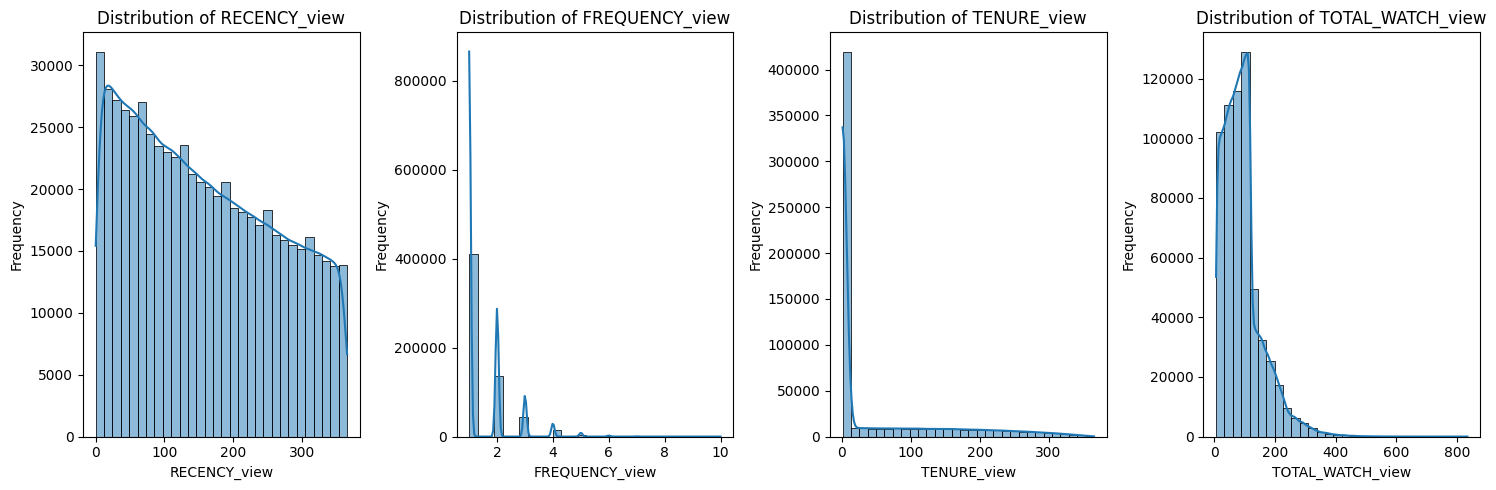

In [22]:
# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot distribution for RECENCY_view
plt.subplot(1, 4, 1)
sns.histplot(view_final['RECENCY_view'], bins=30, kde=True)
plt.title('Distribution of RECENCY_view')
plt.xlabel('RECENCY_view')
plt.ylabel('Frequency')

# Plot distribution for FREQUENCY_view
plt.subplot(1, 4, 2)
sns.histplot(view_final['FREQUENCY_view'], bins=30, kde=True)
plt.title('Distribution of FREQUENCY_view')
plt.xlabel('FREQUENCY_view')
plt.ylabel('Frequency')

# Plot distribution for TENURE_view
plt.subplot(1, 4, 3)
sns.histplot(view_final['TENURE_view'], bins=30, kde=True)
plt.title('Distribution of TENURE_view')
plt.xlabel('TENURE_view')
plt.ylabel('Frequency')

# Plot distribution for TOTAL_WATCH_view
plt.subplot(1, 4, 4)
sns.histplot(view_final['TOTAL_WATCH_view'], bins=30, kde=True)
plt.title('Distribution of TOTAL_WATCH_view')
plt.xlabel('TOTAL_WATCH_view')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

---

In [23]:
# Group by Show Name and calculate the sum of Watch Minutes
top_shows = viewership_df.groupby(['Show Name', 'Genre'], as_index=False)['Watch Minutes'].sum()

# Sort the results in descending order by total watch time
top_shows = top_shows.sort_values(by='Watch Minutes', ascending=False)

# Get the top 10 shows
top_10_shows = top_shows.head(10)

# Display the top 10 shows with their Network and Genre
top_10_shows

,Show Name,Genre,Watch Minutes
49,Midnight Pursuit,Thriller,1702395.0
64,Target Locked,Action,1685100.0
30,Flight Risk,Thriller,1356119.0
8,Blood Oath Vigilante Justice,Adventure,1350750.0
21,Edge Of Extinction,Action,1159211.0
10,Chasing Shadows Elite Unit,Action,1140255.0
57,Retro Scifi Space And Beyond,Sci-Fi,1137969.0
38,Highway Heist,Adventure,1134535.0
82,Vintage Noir Tales Of The 50S,Thriller,1133541.0
79,Unseen Worlds Microscopic Marvels,Nature,1127476.0


In [24]:
# Function to get the top 3 most common genres
def top_n_genres(genres, n=3):
    return genres.value_counts().head(n).index.tolist()

# Group by Network and calculate the sum of Watch Minutes and the top 3 most appeared genres
network_summary = viewership_df.groupby('Network', as_index=False).agg(
    Total_Watch_Minutes=('Watch Minutes', 'sum'),
    Average_Watch_Time=('Watch Minutes', 'mean'),
    Top_3_Genres=('Genre', lambda x: top_n_genres(x, 3))
)

# Display the resulting DataFrame
network_summary = network_summary.sort_values(by='Total_Watch_Minutes', ascending=False)
network_summary

,Network,Total_Watch_Minutes,Average_Watch_Time,Top_3_Genres
11,Pulse,11293419.0,62.844211,"[Action, Adventure, Thriller]"
9,Lime Light,8571352.0,63.103991,"[Lifestyle, Reality TV]"
1,ChillStream,5658048.0,62.959541,"[Nature, Documentary, Travel]"
12,RetroReel,5649385.0,63.032178,"[Adventure, Thriller, Comedy]"
5,HistoryWatch,2863231.0,63.192033,"[Biography, War Drama, Historical Mystery]"
13,StarFlix,2847994.0,62.947441,"[Sci-Fi, Action, Fantasy]"
7,KidsZone,2839573.0,62.911490,"[Kids, Animation, Family]"
14,ThriTV,2835208.0,63.077512,"[Thriller, Drama, Crime]"
10,MindBend,2827474.0,62.957271,"[Thriller, Psychological Thriller, Sci-Fi]"
2,CineQuest,2825918.0,62.827497,"[Mystery, Sci-Fi, Action]"


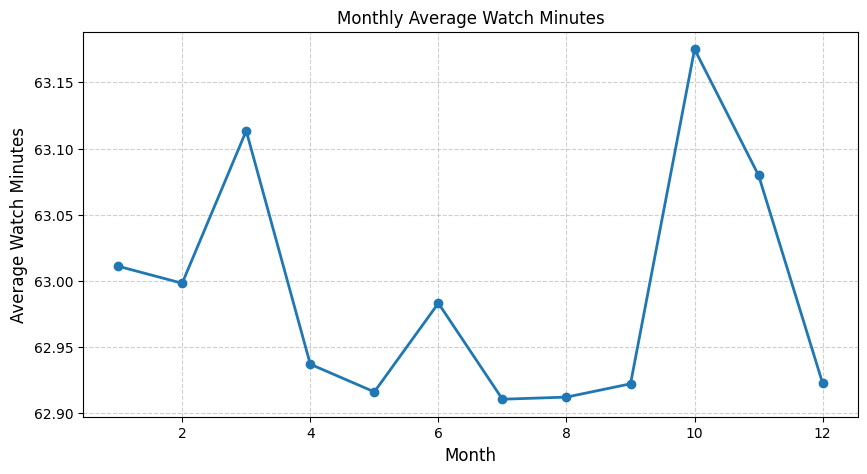

In [25]:
# Assuming 'viewership_df' is available, let's enhance the plot
plt.figure(figsize=(10, 5))
plt.plot(viewership_df.groupby('Month')['Watch Minutes'].mean(), marker='o', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Watch Minutes', fontsize=12)
plt.title('Monthly Average Watch Minutes', fontsize=12)

# Customize grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the improved plot
plt.show()


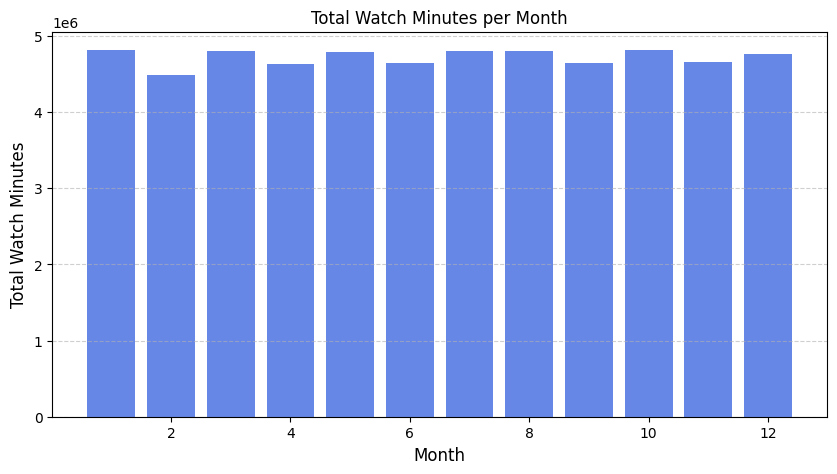

In [26]:
plt.figure(figsize=(10, 5))
plt.bar(viewership_df.groupby('Month')['Watch Minutes'].sum().index, 
        viewership_df.groupby('Month')['Watch Minutes'].sum(),
        color='royalblue', alpha=0.8)

# Add labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Watch Minutes', fontsize=12)
plt.title('Total Watch Minutes per Month', fontsize=12)

# Customize grid and ticks
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the improved plot
plt.show()


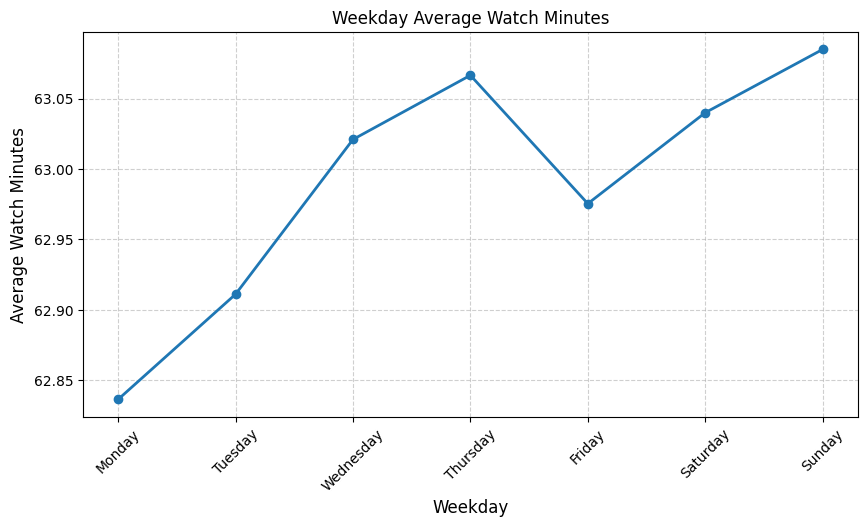

In [27]:
# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
plt.plot(viewership_df.groupby('Weekday')['Watch Minutes'].mean().reindex(weekday_order), 
         marker='o', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Average Watch Minutes', fontsize=12)
plt.title('Weekday Average Watch Minutes', fontsize=12)

# Customize grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the improved plot
plt.show()


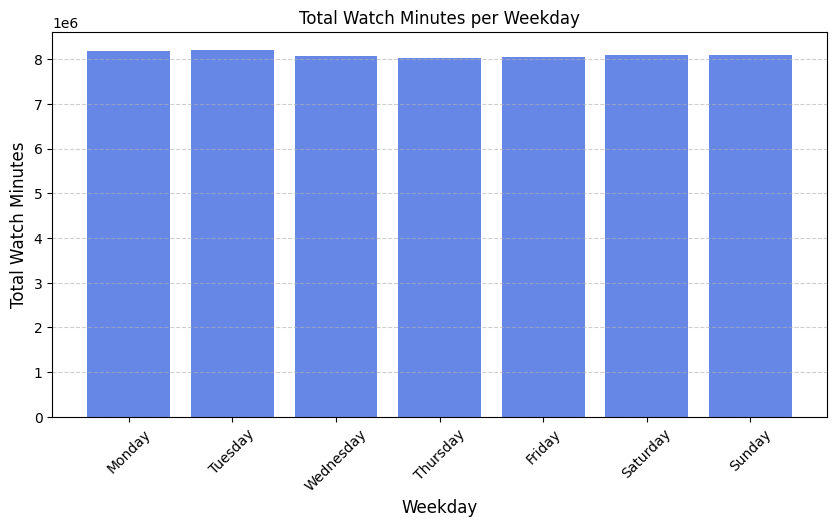

In [28]:
# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
plt.bar(viewership_df.groupby('Weekday')['Watch Minutes'].sum().reindex(weekday_order).index, 
        viewership_df.groupby('Weekday')['Watch Minutes'].sum().reindex(weekday_order),
        color='royalblue', alpha=0.8)

# Add labels and title
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Total Watch Minutes', fontsize=12)
plt.title('Total Watch Minutes per Weekday', fontsize=12)

# Customize grid and ticks
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the improved plot
plt.show()


---
### Subscription and viewership


In [222]:
# Rename the 'BRAND' column to 'Network' in subs_df
subs_df.rename(columns={'BRAND': 'Network'}, inplace=True)
# Convert SUB_START and SUB_END to datetime objects
subs_df['SUB_START'] = pd.to_datetime(subs_df['SUB_START'])
subs_df['SUB_END'] = pd.to_datetime(subs_df['SUB_END'])

subs_df.head()

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,Network,Capstone_id
0,46,2024-04-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,CSD6252924
1,247,2024-02-28,2024-11-01,1,monthly,7.99,95.88,0,PULSE,JRL1424659
2,243,2024-02-01,2024-10-01,1,annual,86.88,86.88,0,PULSE,WCT6844507
3,274,2024-02-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,ZVV0388603
4,214,2024-04-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,LFV8944280


In [224]:
# Group by Capstone_id and BRAND, and find the earliest SUB_START
earliest_sub_start = subs_df.groupby(['Capstone_id', 'Network'], as_index=False)['SUB_START'].min()
earliest_sub_start

,Capstone_id,Network,SUB_START
0,AAA0353325,PULSE,2024-05-17
1,AAA0584604,LIMELIGHT,2024-05-17
2,AAA3493769,PULSE,2024-03-12
3,AAA3691978,CINEQUEST,2024-04-01
4,AAA3822461,PULSE,2024-03-12
...,...,...,...
111663,ZZZ3538627,PULSE,2024-02-01
111664,ZZZ3547894,LIMELIGHT,2024-02-01
111665,ZZZ5131859,PULSE,2024-06-26
111666,ZZZ8287446,PULSE,2024-05-17


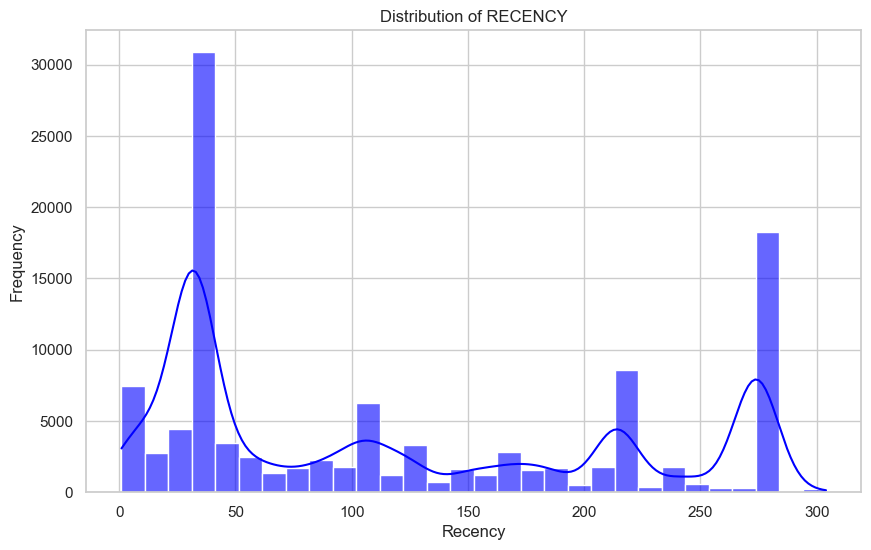

In [200]:
# Create a distribution plot for subs_df.RECENCY
plt.figure(figsize=(10, 6))
sns.histplot(subs_df['RECENCY'], bins=30, kde=True, color='blue', alpha=0.6)

# Set plot title and labels
plt.title('Distribution of RECENCY')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [204]:
# Define the mapping of old values to new values
network_mapping = {
    'Lime Light': 'LIMELIGHT',
    'ChillStream': 'CHILLSTREAM',
    'Pulse': 'PULSE',
    'RetroReel': 'RETROREEL',
    'CineQuest': 'CINEQUEST'
}

# Replace the values in the 'Network' column
viewership_df['Network'] = viewership_df['Network'].replace(network_mapping)

# Display the updated DataFrame to verify the changes
print(viewership_df['Network'].unique()) 

['LIMELIGHT' 'PULSE' 'HeartStream' 'CINEQUEST' 'StarFlix' 'LaughOutLoud'
 'HistoryWatch' 'CHILLSTREAM' 'RETROREEL' 'ThriTV' 'MindBend' 'ActionMax'
 'DocuWorld' 'KidsZone' 'HorrorHaven']


In [234]:
viewership_df['Date Started'] = pd.to_datetime(viewership_df['Time Started'].dt.date)

# Display the updated DataFrame with the new 'Date Started' column
# Create a new DataFrame with the specified columns
viewership_df_2 = viewership_df[['Capstone_id', 'Network', 'Watch Minutes', 'Date Started']].copy()

# Display the new DataFrame
viewership_df_2

,Capstone_id,Network,Watch Minutes,Date Started
0,JZT0614778,LIMELIGHT,20.0,2024-09-05
1,KTE7341320,PULSE,100.0,2024-01-10
2,XAM5059147,HeartStream,37.0,2024-04-16
3,LWK9505947,CINEQUEST,23.0,2024-03-27
4,TED4341658,LIMELIGHT,19.0,2024-10-13
...,...,...,...,...
899995,UYV5357084,HistoryWatch,36.0,2024-04-14
899996,HLU0117318,LIMELIGHT,108.0,2024-12-23
899997,OZO3721643,StarFlix,91.0,2024-08-25
899998,MLI3044962,HistoryWatch,54.0,2024-07-20


In [251]:
# Merge earliest_sub_start with viewership_df_2 on Capstone_id and Network
merged_df = pd.merge(earliest_sub_start, viewership_df_2, on=['Capstone_id', 'Network'], how='outer')
merged_df

,Capstone_id,Network,SUB_START,Watch Minutes,Date Started
0,AAA0353325,CHILLSTREAM,NaT,63.0,2024-08-10
1,AAA0353325,CHILLSTREAM,NaT,23.0,2024-04-07
2,AAA0353325,HorrorHaven,NaT,52.0,2024-04-22
3,AAA0353325,LIMELIGHT,NaT,29.0,2024-10-08
4,AAA0353325,LIMELIGHT,NaT,13.0,2024-04-04
...,...,...,...,...,...
934045,ZZZ8498042,LaughOutLoud,NaT,39.0,2024-08-28
934046,ZZZ8498042,MindBend,NaT,44.0,2024-01-31
934047,ZZZ8498042,PULSE,2024-06-22,50.0,2024-11-12
934048,ZZZ8498042,PULSE,2024-06-22,6.0,2024-06-04


In [252]:
# Check for missing values in the 'Date Started' column
na_count_date_started = merged_df['Date Started'].isna().sum()

# Display the count of missing values
print(f'Number of NAs in Date Started: {na_count_date_started}')

Number of NAs in Date Started: 34050


In [253]:
# Check for missing values in the 'Sub Start' column
na_count_sub_started = merged_df['SUB_START'].isna().sum()

# Display the count of missing values
print(f'Number of NAs in Sub Start: {na_count_sub_started}')

Number of NAs in Sub Start: 752508


In [256]:
# Calculate the total number of entries in merged_df
total_entries = merged_df.shape[0]

# Count the number of NAs in Date Started and SUB_START
na_count_date_started = merged_df['Date Started'].isna().sum()
na_count_sub_start = merged_df['SUB_START'].isna().sum()

# Calculate the percentage of NAs
percentage_na_date_started = (na_count_date_started / total_entries) * 100 if total_entries > 0 else 0
percentage_na_sub_start = (na_count_sub_start / total_entries) * 100 if total_entries > 0 else 0

# Display the results
print(f'Percentage of users subscribed but never viewed free content: {percentage_na_date_started:.2f}%')
print(f'Percentage of users viewed free content but never subscribed: {percentage_na_sub_start:.2f}%')

Percentage of users subscribed but never viewed free content: 3.65%
Percentage of users viewed free content but never subscribed: 80.56%


In [257]:
# Create a copy of merged_df
cleaned_merged_df = merged_df.copy()

# Remove any rows with NaN values
cleaned_merged_df.dropna(inplace=True)

cleaned_merged_df.head()

,Capstone_id,Network,SUB_START,Watch Minutes,Date Started
7,AAA0353325,PULSE,2024-05-17,36.0,2024-12-18
18,AAA0584604,LIMELIGHT,2024-05-17,13.0,2024-04-29
32,AAA3493769,PULSE,2024-03-12,89.0,2024-12-29
33,AAA3493769,PULSE,2024-03-12,10.0,2024-06-15
48,AAA3822461,PULSE,2024-03-12,8.0,2024-11-25


In [260]:
# Calculate the difference between Date Started and SUB_START
cleaned_merged_df['Date Difference'] = (cleaned_merged_df['Date Started'] - cleaned_merged_df['SUB_START']).dt.days

# Group by Capstone_id and Network, and calculate the required metrics
grouped_summary = cleaned_merged_df.groupby(['Capstone_id', 'Network'], as_index=False).agg(
    Min_Date_Difference=('Date Difference', 'min'),
    Max_Date_Difference=('Date Difference', 'max'),
    Number_of_Views=('Date Difference', 'size')
)

grouped_summary

,Capstone_id,Network,Min_Date_Difference,Max_Date_Difference,Number_of_Views
0,AAA0353325,PULSE,215,215,1
1,AAA0584604,LIMELIGHT,-18,-18,1
2,AAA3493769,PULSE,95,292,2
3,AAA3822461,PULSE,-44,258,2
4,AAA6478453,PULSE,27,27,1
...,...,...,...,...,...
77613,ZZZ3538627,PULSE,70,333,5
77614,ZZZ3547894,LIMELIGHT,280,280,1
77615,ZZZ5131859,PULSE,10,186,2
77616,ZZZ8287446,PULSE,-66,-30,2


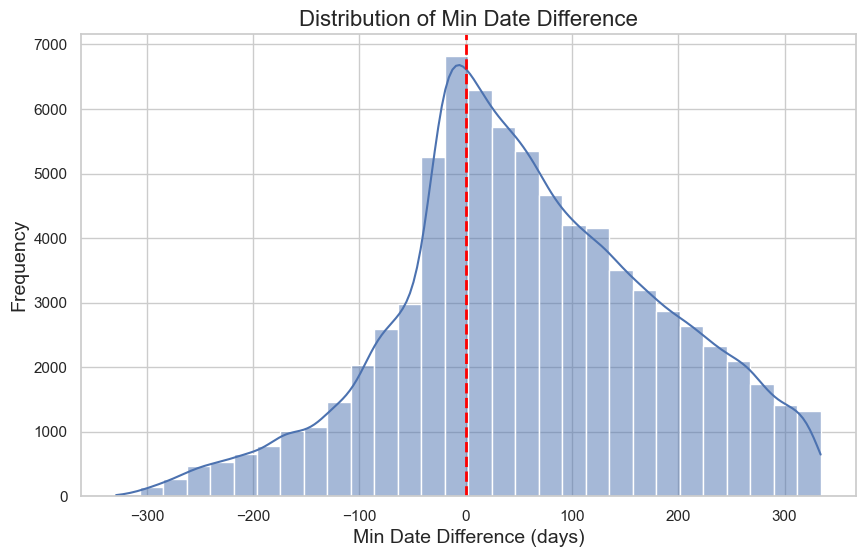

In [264]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(grouped_summary['Min_Date_Difference'], bins=30, kde=True)

# Add a red vertical line at x = 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Distribution of Min Date Difference', fontsize=16)
plt.xlabel('Min Date Difference (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [261]:
# Calculate the total number of entries in Min_Date_Difference
total_entries = grouped_summary['Min_Date_Difference'].count()

# Calculate the number of negative entries in Min_Date_Difference
negative_entries = (grouped_summary['Min_Date_Difference'] < 0).sum()

# Calculate the percentage of negative entries
percentage_negative = (negative_entries / total_entries) * 100 if total_entries > 0 else 0

# Display the result
print(f'Percentage of users viewed content from the Network before their subscriptions start: {percentage_negative:.2f}%')

Percentage of users viewed content before subscription start: 32.52%


In [262]:
# Calculate the total number of entries in Max_Date_Difference
total_entries_max = grouped_summary['Max_Date_Difference'].count()

# Calculate the number of positive entries in Max_Date_Difference
positive_entries_max = (grouped_summary['Max_Date_Difference'] > 0).sum()

# Calculate the percentage of positive entries
percentage_positive = (positive_entries_max / total_entries_max) * 100 if total_entries_max > 0 else 0

# Display the result
print(f'Percentage of users viewed content after subscription start: {percentage_positive:.2f}%')

Percentage of users viewed content after subscription start: 86.03%


In [211]:
# Merge the two DataFrames on 'Capstone id' and 'Network'
merged_data = pd.merge(viewership_df, subs_df, on=['Capstone_id', 'Network'], how='inner')

# Display the first few rows of the merged DataFrame
merged_data.head()

,Capstone_id,Time Started,Time Ended,Show Name,Network,Genre,Watch Minutes,Year,Month,Weekday,Date Started,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER
0,WOC3796420,2024-02-03 18:19:00,2024-02-03 19:40:00,The Last Outpost,PULSE,Action,81.0,2024,2,Saturday,2024-02-03,55,2024-09-07,2024-11-01,1,monthly,7.99,95.88,0
1,GVY7319483,2024-03-18 05:18:00,2024-03-18 06:55:00,Edge Of Extinction,PULSE,Action,97.0,2024,3,Monday,2024-03-18,32,2024-02-01,2024-03-04,1,annual,86.88,86.88,0
2,WGN5823129,2024-05-12 03:21:00,2024-05-12 04:02:00,Highway Heist,PULSE,Adventure,41.0,2024,5,Sunday,2024-05-12,75,2024-08-18,2024-11-01,1,monthly,11.99,143.88,0
3,NHC8102553,2024-06-27 10:09:00,2024-06-27 11:23:00,Heroes Of The West Old Cowboy Adventures,RETROREEL,Western,74.0,2024,6,Thursday,2024-06-27,32,2024-02-01,2024-03-04,1,monthly,9.99,119.88,0
4,VGP8474701,2024-02-09 05:24:00,2024-02-09 06:18:00,Edge Of Extinction,PULSE,Action,54.0,2024,2,Friday,2024-02-09,107,2024-02-01,2024-05-18,1,monthly,7.99,95.88,0


In [212]:
# Ensure the relevant columns are in datetime format
merged_data['Time Started'] = pd.to_datetime(merged_data['Time Started'])
merged_data['SUB_START'] = pd.to_datetime(merged_data['SUB_START'])
merged_data['SUB_END'] = pd.to_datetime(merged_data['SUB_END'])

# Check if 'Time Started' is between 'SUB_START' and 'SUB_END'
merged_data['In Subscription Period'] = merged_data['Time Started'].between(merged_data['SUB_START'], merged_data['SUB_END'])

merged_data[['Capstone_id', 'Time Started', 'Time Ended', 'Network', 'SUB_START', 'SUB_END', 'In Subscription Period']]

,Capstone_id,Time Started,Time Ended,Network,SUB_START,SUB_END,In Subscription Period
0,WOC3796420,2024-02-03 18:19:00,2024-02-03 19:40:00,PULSE,2024-09-07,2024-11-01,False
1,GVY7319483,2024-03-18 05:18:00,2024-03-18 06:55:00,PULSE,2024-02-01,2024-03-04,False
2,WGN5823129,2024-05-12 03:21:00,2024-05-12 04:02:00,PULSE,2024-08-18,2024-11-01,False
3,NHC8102553,2024-06-27 10:09:00,2024-06-27 11:23:00,RETROREEL,2024-02-01,2024-03-04,False
4,VGP8474701,2024-02-09 05:24:00,2024-02-09 06:18:00,PULSE,2024-02-01,2024-05-18,True
...,...,...,...,...,...,...,...
147487,MEW0682081,2024-07-07 08:55:00,2024-07-07 09:12:00,CINEQUEST,2024-02-01,2024-03-04,False
147488,NOV7632041,2024-09-22 07:07:00,2024-09-22 07:36:00,PULSE,2024-07-15,2024-11-01,True
147489,RXR5382500,2024-07-14 15:16:00,2024-07-14 15:54:00,PULSE,2024-07-01,2024-11-22,True
147490,TIV0921164,2024-09-15 09:24:00,2024-09-15 10:14:00,PULSE,2024-02-26,2024-03-04,False


In [213]:
merged_data['In Subscription Period'].value_counts()

In Subscription Period
False    100873
True      46619
Name: count, dtype: int64

---
### Clustering for Viewership and Online Content

In [29]:
## Helper Function for Clustering

def plot_sse_elbow(data, columns, k_range=range(1, 10), max_iter=1000):
    """
    Plots SSE for a range of cluster numbers to help determine the optimal number of clusters.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - k_range: range of cluster numbers to try (default is range(1, 10)).
    - max_iter: maximum number of iterations for the KMeans algorithm (default is 1000).
    """
    sse = {}
    X = data[[columns]]
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state=seed)
        kmeans.fit(X)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Optimal k")
    plt.show()

def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

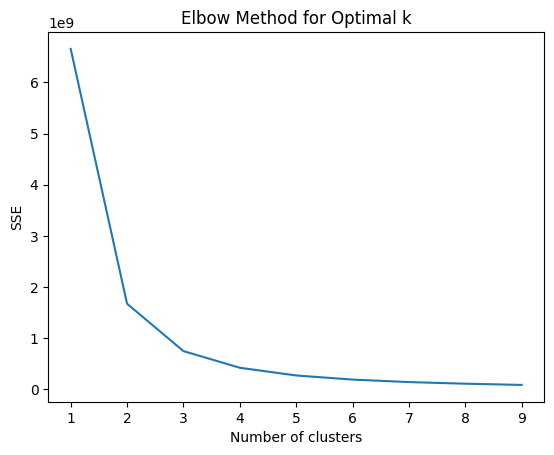

In [32]:
plot_sse_elbow(view_final, 'RECENCY_view')

In [33]:
view_final = perform_kmeans(view_final, 'RECENCY_view', 3, 'RecencyCluster_view')
view_final = order_cluster('RecencyCluster_view', 'RECENCY_view', view_final, False)
view_final.groupby('RecencyCluster_view')['RECENCY_view'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster_view,,,,,,,,
0,170872.0,295.739688,38.692402,232.0,262.0,294.0,329.0,366.0
1,202445.0,167.767275,35.225324,110.0,137.0,166.0,198.0,231.0
2,236648.0,52.181244,31.682901,0.0,24.0,51.0,79.0,109.0


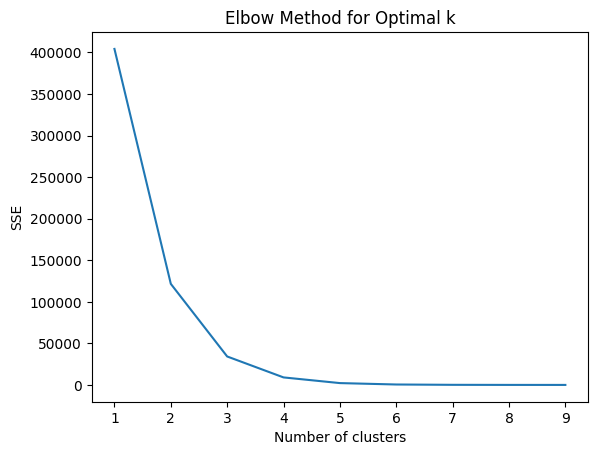

In [34]:
plot_sse_elbow(view_final, 'FREQUENCY_view')

In [36]:
view_final = perform_kmeans(view_final, 'FREQUENCY_view', 3, 'FrequencyCluster_view')
view_final = order_cluster('FrequencyCluster_view', 'FREQUENCY_view', view_final, True)
view_final.groupby('FrequencyCluster_view')['FREQUENCY_view'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster_view,,,,,,,,
0,409960.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,136631.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,63374.0,3.420614,0.734919,3.0,3.0,3.0,4.0,10.0


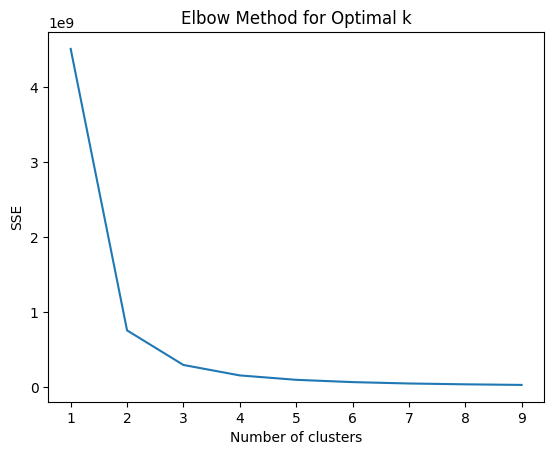

In [37]:
plot_sse_elbow(view_final, 'TENURE_view')

In [38]:
view_final = perform_kmeans(view_final, 'TENURE_view', 3, 'TenureCluster_view')
view_final = order_cluster('TenureCluster_view', 'TENURE_view', view_final, True)
view_final.groupby('TenureCluster_view')['TENURE_view'].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster_view,,,,,,,,
0,457355.0,4.252825,11.251908,1.0,1.0,1.0,1.0,64.0
1,86212.0,125.326196,35.923073,65.0,94.0,124.0,156.0,189.0
2,66398.0,254.297132,43.303056,190.0,217.0,249.0,287.0,366.0


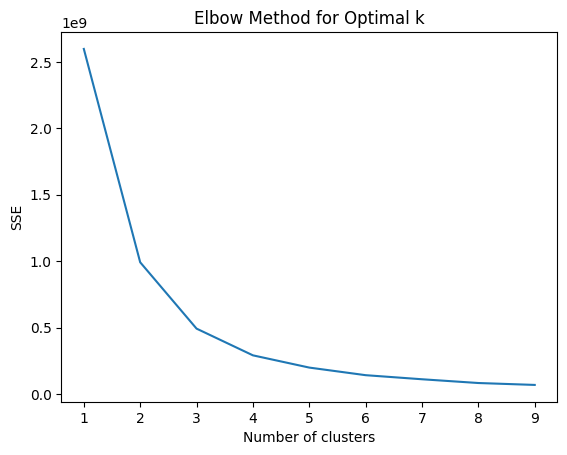

In [40]:
plot_sse_elbow(view_final, 'TOTAL_WATCH_view')

In [41]:
view_final = perform_kmeans(view_final, 'TOTAL_WATCH_view', 3, 'DurationCluster_view')
view_final = order_cluster('DurationCluster_view', 'TOTAL_WATCH_view', view_final, True)
view_final.groupby('DurationCluster_view')['TOTAL_WATCH_view'].describe()

,count,mean,std,min,25%,50%,75%,max
DurationCluster_view,,,,,,,,
0,268033.0,41.155824,19.900495,6.0,24.0,42.0,58.0,74.0
1,268237.0,107.797768,22.912894,75.0,90.0,104.0,119.0,167.0
2,73695.0,227.215238,57.647155,168.0,186.0,209.0,250.0,834.0


In [43]:
view_final

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view,OverallScore_view
0,AAA0353325,ChillStream,143,2,126,86.0,1,1,1,1,4
1,AAA0353325,HorrorHaven,253,1,1,52.0,0,0,0,0,0
2,AAA0353325,Lime Light,36,3,235,54.0,2,2,2,0,6
3,AAA0353325,MindBend,264,1,1,77.0,0,0,0,1,1
4,AAA0353325,Pulse,13,1,1,36.0,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
609960,ZZZ8498042,ChillStream,63,3,227,191.0,2,2,2,2,8
609961,ZZZ8498042,LaughOutLoud,125,1,1,39.0,1,0,0,0,1
609962,ZZZ8498042,MindBend,335,1,1,44.0,0,0,0,0,0
609963,ZZZ8498042,Pulse,49,2,162,56.0,2,1,1,0,4


In [44]:
view_final['OverallScore_view'] = view_final['RecencyCluster_view'] + view_final['FrequencyCluster_view'] + view_final['TenureCluster_view'] + view_final['DurationCluster_view']
view_final.groupby('OverallScore_view')[['RECENCY_view','FREQUENCY_view','TENURE_view','TOTAL_WATCH_view']].mean()

,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view
OverallScore_view,,,,
0,298.750075,1.000000,1.000000,39.989763
1,225.373846,1.013644,1.385779,64.157745
2,116.878921,1.084276,3.792400,67.703519
3,96.477230,1.326855,18.870364,101.822217
4,131.747600,2.049793,91.717084,122.656313
5,92.034133,2.163299,135.758635,136.285627
6,77.378448,2.448400,192.803987,161.994437
7,58.384857,3.003428,211.504977,198.692222
8,43.156349,3.734176,266.372301,257.692211


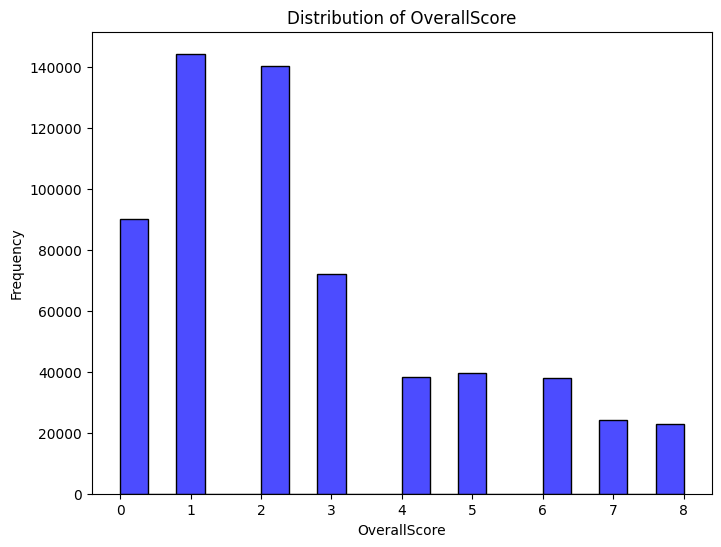

In [46]:
## Visualization
plt.figure(figsize=(8, 6))
sns.histplot(view_final['OverallScore_view'], kde=False, bins=20, color="blue", alpha = 0.7)
plt.title('Distribution of OverallScore')
plt.xlabel('OverallScore')
plt.ylabel('Frequency')
plt.show()

In [48]:
online_final

,Capstone_id,Network,RECENCY_online,FREQUENCY_online,TENURE_online
0,AAA0353325,CineQuest,269,1,1
1,AAA0353325,DocuWorld,206,1,1
2,AAA0353325,HeartStream,113,2,145
3,AAA0353325,HistoryWatch,116,1,1
4,AAA0353325,HorrorHaven,55,2,155
...,...,...,...,...,...
561510,ZZZ8498042,ActionMax,199,1,1
561511,ZZZ8498042,ChillStream,127,1,1
561512,ZZZ8498042,CineQuest,35,1,1
561513,ZZZ8498042,KidsZone,364,1,1


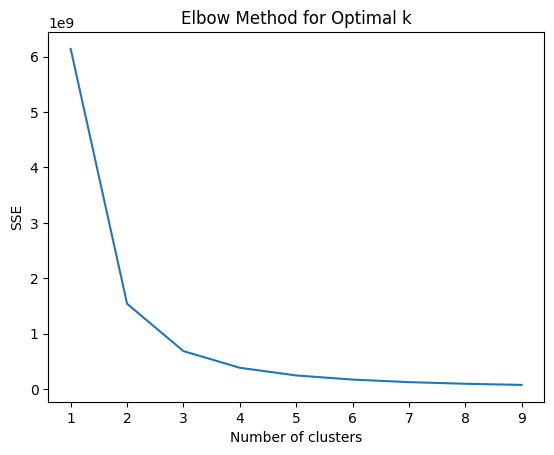

In [47]:
## clustering for Online Content
plot_sse_elbow(online_final, 'RECENCY_online')

In [49]:
online_final = perform_kmeans(online_final, 'RECENCY_online', 3, 'RecencyCluster_online')
online_final = order_cluster('RecencyCluster_online', 'RECENCY_online', online_final, False)
online_final.groupby('RecencyCluster_online')['RECENCY_online'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster_online,,,,,,,,
0,161542.0,299.903220,37.197958,238.0,267.0,299.0,332.0,366.0
1,185502.0,174.889370,34.935046,117.0,144.0,174.0,205.0,237.0
2,214471.0,57.141133,33.212805,2.0,28.0,56.0,86.0,116.0


/Users/russellxia/Desktop/NYU_DS/Horizon25/.conda/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


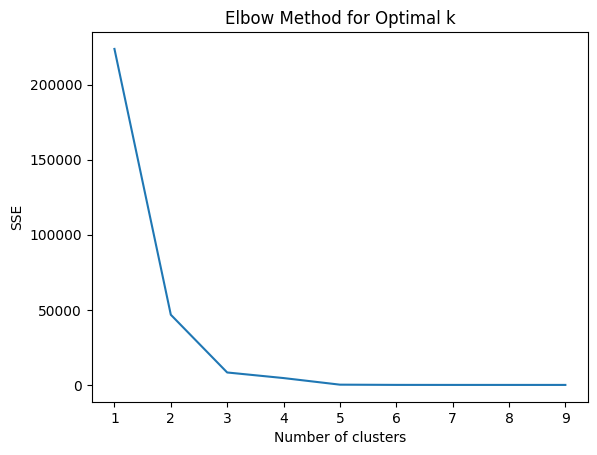

In [50]:
plot_sse_elbow(online_final, 'FREQUENCY_online')

In [51]:
online_final = perform_kmeans(online_final, 'FREQUENCY_online', 3, 'FrequencyCluster_online')
online_final = order_cluster('FrequencyCluster_online', 'FREQUENCY_online', online_final, True)
online_final.groupby('FrequencyCluster_online')['FREQUENCY_online'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster_online,,,,,,,,
0,411974.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,116458.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,33083.0,3.221715,0.500611,3.0,3.0,3.0,3.0,8.0


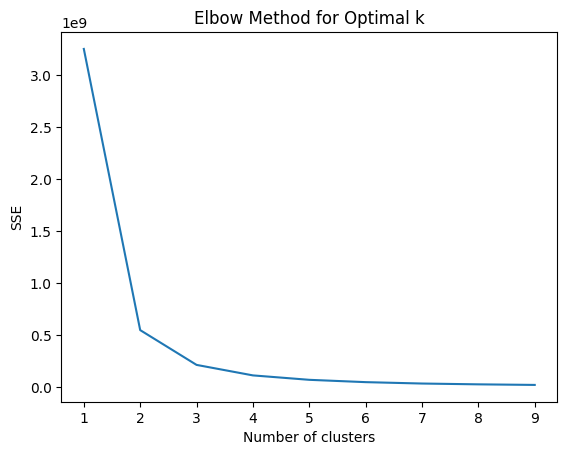

In [52]:
plot_sse_elbow(online_final, 'TENURE_online')

In [53]:
online_final = perform_kmeans(online_final, 'TENURE_online', 3, 'TenureCluster_online')
online_final = order_cluster('TenureCluster_online', 'TENURE_online', online_final, True)
online_final.groupby('TenureCluster_online')['TENURE_online'].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster_online,,,,,,,,
0,449457.0,3.492781,9.671595,1.0,1.0,1.0,1.0,61.0
1,65212.0,119.718886,35.008004,62.0,89.0,118.0,149.0,183.0
2,46846.0,248.227469,44.110977,184.0,211.0,242.0,280.0,365.0


In [56]:
online_final['OverallScore_online'] = online_final['RecencyCluster_online'] + online_final['FrequencyCluster_online'] + online_final['TenureCluster_online']
online_final.groupby('OverallScore_online')[['RECENCY_online','FREQUENCY_online','TENURE_online']].mean()

,RECENCY_online,FREQUENCY_online,TENURE_online
OverallScore_online,,,
0,302.113031,1.000000,1.000000
1,184.938734,1.071251,2.903817
2,75.728415,1.122543,6.178677
3,136.564900,2.043943,87.118048
4,86.831163,2.213047,131.030220
5,57.003451,2.298655,225.246653
6,47.585662,3.307182,260.293906


In [57]:
# join online_final and view_final
online_final

,Capstone_id,Network,RECENCY_online,FREQUENCY_online,TENURE_online,RecencyCluster_online,FrequencyCluster_online,TenureCluster_online,OverallScore_online
0,AAA0353325,CineQuest,269,1,1,0,0,0,0
1,AAA0353325,DocuWorld,206,1,1,1,0,0,1
2,AAA0353325,HeartStream,113,2,145,2,1,1,4
3,AAA0353325,HistoryWatch,116,1,1,2,0,0,2
4,AAA0353325,HorrorHaven,55,2,155,2,1,1,4
...,...,...,...,...,...,...,...,...,...
561510,ZZZ8498042,ActionMax,199,1,1,1,0,0,1
561511,ZZZ8498042,ChillStream,127,1,1,1,0,0,1
561512,ZZZ8498042,CineQuest,35,1,1,2,0,0,2
561513,ZZZ8498042,KidsZone,364,1,1,0,0,0,0


In [59]:
# Assuming view_final and online_final are your DataFrames
view_online = pd.merge(view_final, online_final, on=['Capstone_id', 'Network'], how='inner')

view_online

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view,OverallScore_view,RECENCY_online,FREQUENCY_online,TENURE_online,RecencyCluster_online,FrequencyCluster_online,TenureCluster_online,OverallScore_online
0,AAA0353325,HorrorHaven,253,1,1,52.0,0,0,0,0,0,55,2,155,2,1,1,4
1,AAA0353325,Lime Light,36,3,235,54.0,2,2,2,0,6,25,2,65,2,1,1,4
2,AAA0353325,Pulse,13,1,1,36.0,2,0,0,0,2,47,1,1,2,0,0,2
3,AAA0353325,RetroReel,24,3,240,217.0,2,2,2,2,8,298,1,1,0,0,0,0
4,AAA0584604,ChillStream,152,3,99,234.0,1,2,1,2,6,286,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264100,ZZZ8287446,ChillStream,140,3,209,159.0,1,2,2,1,6,274,1,1,0,0,0,0
264101,ZZZ8287446,HorrorHaven,237,1,1,100.0,0,0,0,1,1,221,1,1,1,0,0,1
264102,ZZZ8287446,Lime Light,96,2,179,207.0,2,1,1,2,6,282,2,40,0,1,0,1
264103,ZZZ8498042,ActionMax,362,1,1,46.0,0,0,0,0,0,199,1,1,1,0,0,1
